# I - IMPORTS and CONFIGURATION

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
keras = tf.keras
layers = tf.keras.layers
models = tf.keras.models
callbacks = tf.keras.callbacks
applications = tf.keras.applications

# Imports for ViT (Hugging Face / PyTorch)
import torch
import torchvision.transforms as T # Added for ViT Augmentation
from datasets import Dataset, DatasetDict, Image, ClassLabel, Features
from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments, Trainer

# Disable layout optimizer
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# System Configuration
SEED = 64
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
torch.manual_seed(SEED)

DATA_DIR = '/kaggle/input/blood-cells-image-dataset/bloodcells_dataset'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
CHANNELS = 3

# Toggle DEBUG to True for a quick test run (3 epochs), False for full training
DEBUG = False
if DEBUG:
    EPOCHS_KERAS = 3
    EPOCHS_VIT = 2
else:
    EPOCHS_KERAS = 30
    EPOCHS_VIT = 8

LEARNING_RATE = 1e-4

print(f"Running with Seed: {SEED}")
print(f"Debug Mode: {DEBUG}")

2026-02-08 12:24:30.607086: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770553470.785179      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770553470.835904      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770553471.257405      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770553471.257450      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770553471.257453      24 computation_placer.cc:177] computation placer alr

Running with Seed: 64
Debug Mode: False


# II - DATA LOADING

Found classes: ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']

Total images: 17092
Number of classes: 8


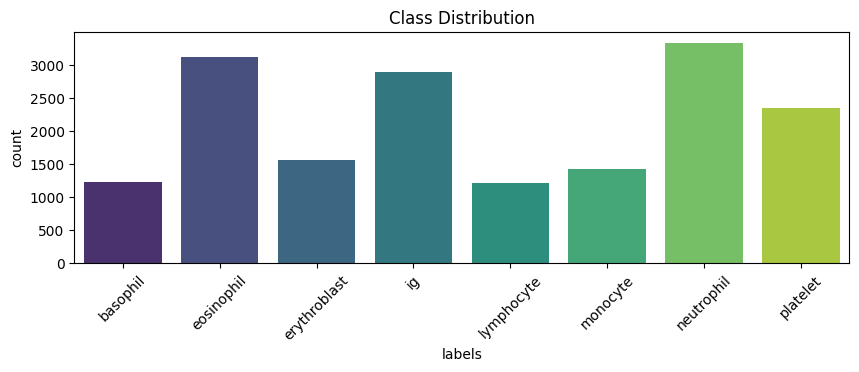

Train set: 11964
Valid set: 2564
Test set:  2564


In [2]:
def load_file_paths(data_dir):
    filepaths = []
    labels = []
    
    if not os.path.exists(data_dir):
        print(f"Error: Directory {data_dir} not found.")
        return [], []

    folds = sorted(os.listdir(data_dir))
    print(f"Found classes: {folds}")
    
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        if os.path.isdir(foldpath):    
            filelist = os.listdir(foldpath)
            for file in filelist:
                filepaths.append(os.path.join(foldpath, file))
                labels.append(fold)
    return filepaths, labels

filepaths, labels = load_file_paths(DATA_DIR)
df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

# Create label mappings
label_map = {label: i for i, label in enumerate(sorted(set(labels)))}
idx_to_label = {v: k for k, v in label_map.items()}
df['label_idx'] = df['labels'].map(label_map)
NUM_CLASSES = len(label_map)
CLASS_NAMES = [idx_to_label[i] for i in range(NUM_CLASSES)]

print(f"\nTotal images: {len(df)}")
print(f"Number of classes: {NUM_CLASSES}")

# EDA Plot
plt.figure(figsize=(10, 3))
sns.countplot(x=df['labels'], palette='viridis', hue=df['labels'], legend=False)
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

# Splitting
train_df, dummy_df = train_test_split(df, train_size=0.7, shuffle=True, random_state=SEED, stratify=df['labels'])
valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=SEED, stratify=dummy_df['labels'])

print(f"Train set: {len(train_df)}")
print(f"Valid set: {len(valid_df)}")
print(f"Test set:  {len(test_df)}")

# III - KERAS DATASET

In [3]:
def preprocess_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    label = tf.one_hot(label, NUM_CLASSES)
    return img, label

def create_dataset(dataframe, is_train=False):
    ds = tf.data.Dataset.from_tensor_slices((dataframe['filepaths'].values, dataframe['label_idx'].values))
    ds = ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    if is_train:
        ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = create_dataset(train_df, is_train=True)
val_ds = create_dataset(valid_df)
test_ds = create_dataset(test_df)

# Define Data Augmentation Layer
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
], name="data_augmentation")

def se_block(x, r=8):
    filters = x.shape[-1]
    se = layers.GlobalAveragePooling2D()(x)
    se = layers.Dense(filters // r, activation='relu')(se)
    se = layers.Dense(filters, activation='sigmoid')(se)
    se = layers.Reshape((1, 1, filters))(se)
    return layers.Multiply()([x, se])

I0000 00:00:1770553500.091330      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


# IV - KERAS MODELS

## *model 1* - BASIC SHALLOW CNN

In [4]:
def build_basic_shallow(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    
    x = layers.Conv2D(32, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = layers.Conv2D(64, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = layers.Conv2D(128, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return keras.Model(inputs, outputs, name="1_Basic_Shallow_CNN")

## *model 2* - SHALLOW CNN + ATTENTION

In [5]:
def build_shallow_attention(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    
    x = layers.Conv2D(32, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = se_block(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = layers.Conv2D(64, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = se_block(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = layers.Conv2D(128, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = se_block(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation='relu')(x)
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return keras.Model(inputs, outputs, name="2_Shallow_SE_CNN")

## *model 3* - EFFICIENTNET B3

In [6]:
def build_robust_efficientnet(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.Rescaling(255.0)(x)
    
    base_model = applications.EfficientNetB3(include_top=False, weights='imagenet', input_tensor=x)
    base_model.trainable = True 
    
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return keras.Model(inputs, outputs, name="3_EfficientNetB3_Robust")

# V - KERAS TRAINING

In [7]:
models_dict = {
    "Basic_Shallow": build_basic_shallow(IMG_SIZE + (CHANNELS,), NUM_CLASSES),
    "Shallow_Attention": build_shallow_attention(IMG_SIZE + (CHANNELS,), NUM_CLASSES),
    "EfficientNetB3": build_robust_efficientnet(IMG_SIZE + (CHANNELS,), NUM_CLASSES)
}

history_dict = {}
evaluation_results = []

for name, model in models_dict.items():
    print(f"\n\n{'='*40}")
    print(f"TRAINING MODEL: {name}")
    print(f"{'='*40}")
    
    lr = 1e-5 if "EfficientNet" in name else 1e-4
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    checkpoint_name = f"{name}_best.keras"
    cbs = [
        callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss"),
        callbacks.ReduceLROnPlateau(factor=0.5, patience=2, verbose=1),
        callbacks.ModelCheckpoint(checkpoint_name, save_best_only=True, monitor="val_loss")
    ]
    
    hist = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS_KERAS,
        callbacks=cbs,
        verbose=1
    )
    
    history_dict[name] = hist
    
    print(f"Loading best weights from {checkpoint_name}...")
    model.load_weights(checkpoint_name)
    
    loss, acc = model.evaluate(test_ds, verbose=0)
    print(f"--> {name} Final Test Accuracy: {acc:.4f}")
    evaluation_results.append({"Model": name, "Accuracy": acc})

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


TRAINING MODEL: Basic_Shallow
Epoch 1/30


I0000 00:00:1770553512.083395      63 cuda_dnn.cc:529] Loaded cuDNN version 91002


374/374 ━━━━━━━━━━━━━━━━━━━━ 45s 96ms/step - accuracy: 0.3136 - loss: 2.4849 - val_accuracy: 0.3413 - val_loss: 1.8466 - learning_rate: 1.0000e-04
Epoch 2/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 34s 88ms/step - accuracy: 0.5356 - loss: 1.2070 - val_accuracy: 0.7317 - val_loss: 0.7929 - learning_rate: 1.0000e-04
Epoch 3/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 33s 87ms/step - accuracy: 0.6213 - loss: 1.0112 - val_accuracy: 0.7933 - val_loss: 0.6137 - learning_rate: 1.0000e-04
Epoch 4/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 33s 87ms/step - accuracy: 0.6479 - loss: 0.9438 - val_accuracy: 0.8132 - val_loss: 0.5392 - learning_rate: 1.0000e-04
Epoch 5/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 33s 87ms/step - accuracy: 0.6589 - loss: 0.9054 - val_accuracy: 0.8401 - val_loss: 0.4889 - learning_rate: 1.0000e-04
Epoch 6/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 32s 84ms/step - accuracy: 0.6616 - loss: 0.8826 - val_accuracy: 0.7956 - val_loss: 0.5428 - learning_rate: 1.0000e-04
Epoch 7/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy

E0000 00:00:1770555076.051848      24 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/3_EfficientNetB3_Robust_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


374/374 ━━━━━━━━━━━━━━━━━━━━ 252s 514ms/step - accuracy: 0.2696 - loss: 2.4572 - val_accuracy: 0.7871 - val_loss: 0.6433 - learning_rate: 1.0000e-05
Epoch 2/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 186s 493ms/step - accuracy: 0.7146 - loss: 0.8542 - val_accuracy: 0.8740 - val_loss: 0.3684 - learning_rate: 1.0000e-05
Epoch 3/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 187s 497ms/step - accuracy: 0.8365 - loss: 0.4862 - val_accuracy: 0.9072 - val_loss: 0.2606 - learning_rate: 1.0000e-05
Epoch 4/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 187s 497ms/step - accuracy: 0.8891 - loss: 0.3368 - val_accuracy: 0.9239 - val_loss: 0.2059 - learning_rate: 1.0000e-05
Epoch 5/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 188s 499ms/step - accuracy: 0.9123 - loss: 0.2687 - val_accuracy: 0.9345 - val_loss: 0.1832 - learning_rate: 1.0000e-05
Epoch 6/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 187s 498ms/step - accuracy: 0.9242 - loss: 0.2273 - val_accuracy: 0.9470 - val_loss: 0.1573 - learning_rate: 1.0000e-05
Epoch 7/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 188s 501ms/

# VI - KERAS EVALUATION

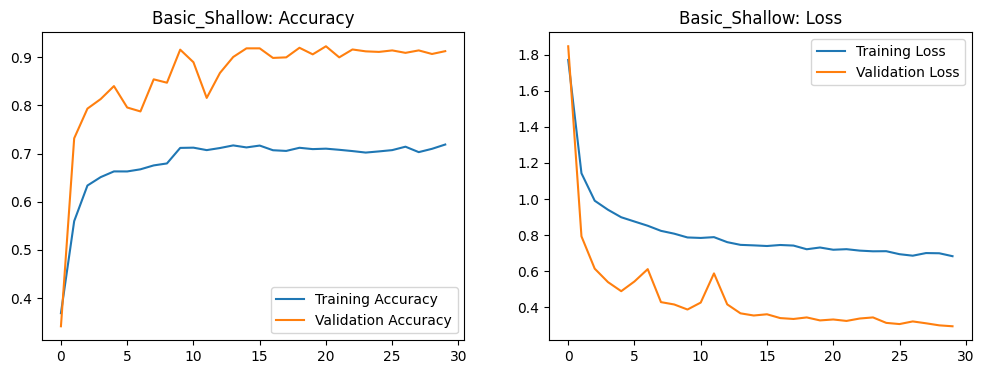

Generating Confusion Matrix for Basic_Shallow...


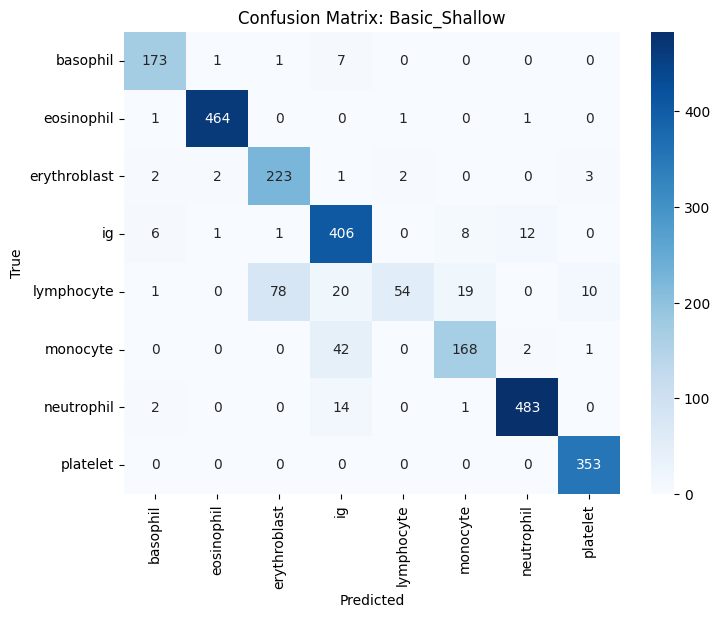

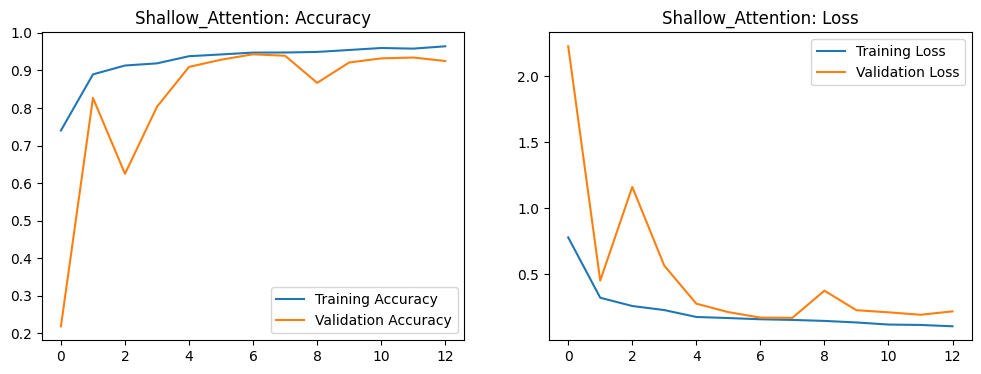

Generating Confusion Matrix for Shallow_Attention...


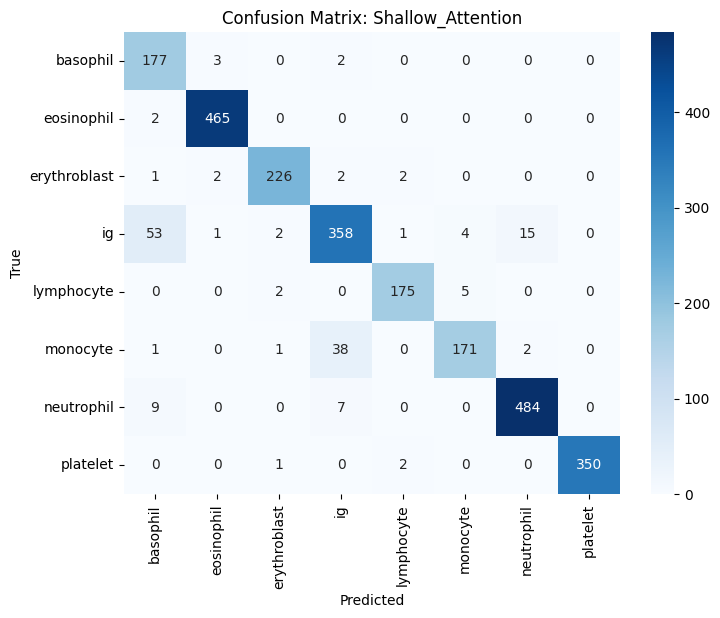

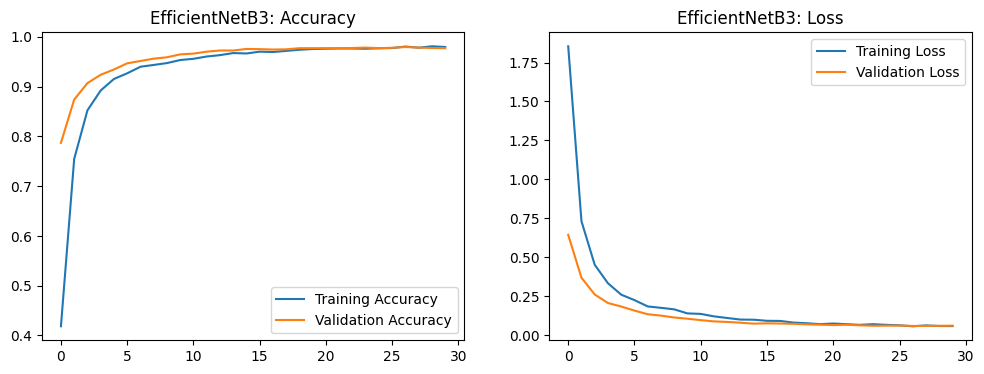

Generating Confusion Matrix for EfficientNetB3...


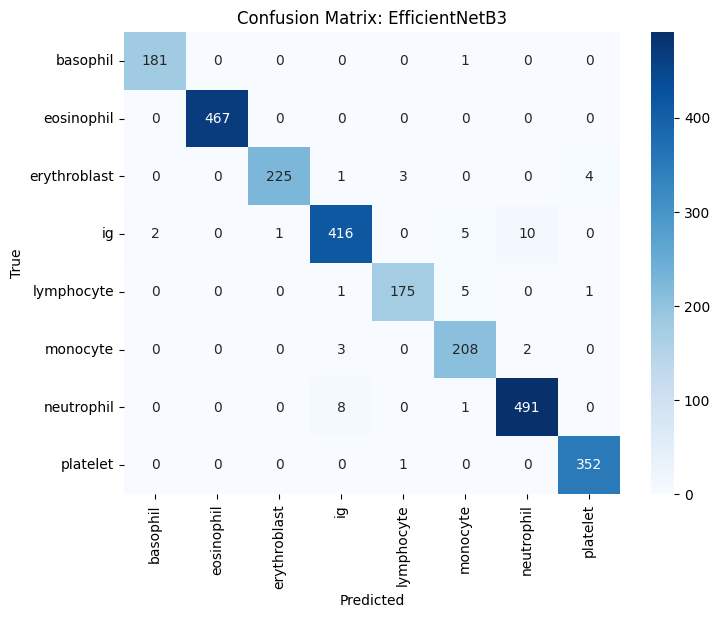

In [8]:
def evaluate_keras_model(model, history, name, test_ds, class_names):
    # Plot Curves
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{name}: Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{name}: Loss')
    plt.show()

    # Confusion Matrix
    print(f"Generating Confusion Matrix for {name}...")
    test_images = []
    test_labels = []
    for img, label in test_ds:
        test_images.append(img.numpy())
        test_labels.append(label.numpy())
    
    test_images = np.concatenate(test_images, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)
    test_labels_idx = np.argmax(test_labels, axis=1)

    predictions = model.predict(test_images, verbose=0)
    pred_labels_idx = np.argmax(predictions, axis=1)

    cm = confusion_matrix(test_labels_idx, pred_labels_idx)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix: {name}')
    plt.show()


# Evaluate
for name, model in models_dict.items():
    hist = history_dict[name]
    evaluate_keras_model(model, hist, name, test_ds, CLASS_NAMES)


# Clear Keras session to free up GPU memory for ViT
tf.keras.backend.clear_session()

# VII - ViT MODEL (HUGGING FACE)

## Data Preparation for Hugging Face

In [9]:
train_df_vit = train_df.copy().drop(columns=['label_idx'])
valid_df_vit = valid_df.copy().drop(columns=['label_idx'])
test_df_vit = test_df.copy().drop(columns=['label_idx'])

label_names = sorted(train_df_vit["labels"].unique().tolist())
class_label = ClassLabel(names=label_names)

# Convert string labels to integer indices
train_df_vit["labels"] = train_df_vit["labels"].apply(lambda x: class_label.str2int(x))
valid_df_vit["labels"] = valid_df_vit["labels"].apply(lambda x: class_label.str2int(x))
test_df_vit["labels"]  = test_df_vit["labels"].apply(lambda x: class_label.str2int(x))

# Create HF Datasets
hf_train = Dataset.from_pandas(train_df_vit.rename(columns={"filepaths": "image_file_path"}), preserve_index=False)
hf_valid = Dataset.from_pandas(valid_df_vit.rename(columns={"filepaths": "image_file_path"}), preserve_index=False)
hf_test  = Dataset.from_pandas(test_df_vit.rename(columns={"filepaths": "image_file_path"}), preserve_index=False)

features = Features({
    "image_file_path": Image(),
    "image": Image(),
    "labels": class_label
})

def add_image_column(example):
    example["image"] = example["image_file_path"]
    return example

def prepare_dataset(ds):
    ds = ds.cast_column("image_file_path", Image())
    ds = ds.map(add_image_column)
    ds = ds.cast(features)
    return ds

hf_train = prepare_dataset(hf_train)
hf_valid = prepare_dataset(hf_valid)
hf_test  = prepare_dataset(hf_test)

dataset_ViT = DatasetDict({
    "train": hf_train,
    "validation": hf_valid,
    "test": hf_test
})

Map:   0%|          | 0/11964 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/11964 [00:00<?, ? examples/s]

Map:   0%|          | 0/2564 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/2564 [00:00<?, ? examples/s]

Map:   0%|          | 0/2564 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/2564 [00:00<?, ? examples/s]

## ViT Model and Processor

In [10]:
model_name_or_path = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_name_or_path)

train_transforms = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.RandomRotation(degrees=45),
    T.ColorJitter(brightness=0.1, contrast=0.1),
    T.ToTensor(),
])

val_transforms = T.Compose([
    T.ToTensor(),
])


def train_transforms_func(batch):    
    augmented_images = []

    augment_pil = T.Compose([
        T.RandomHorizontalFlip(),
        T.RandomVerticalFlip(),
        T.RandomRotation(degrees=45),
        T.ColorJitter(brightness=0.1, contrast=0.1),
    ])
    
    augmented_images = [augment_pil(x) for x in batch['image']]
    
    inputs = processor(augmented_images, return_tensors='pt')
    inputs['labels'] = batch['labels']
    return inputs

def val_transforms_func(batch):
    inputs = processor([x for x in batch['image']], return_tensors='pt')
    inputs['labels'] = batch['labels']
    return inputs


dataset_ViT["train"].set_transform(train_transforms_func)
dataset_ViT["validation"].set_transform(val_transforms_func)
dataset_ViT["test"].set_transform(val_transforms_func)

labels = dataset_ViT['train'].features['labels'].names
model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## ViT Training and Evaluation

In [11]:
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {"accuracy": accuracy_score(p.label_ids, preds)}

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

training_args = TrainingArguments(
    output_dir="./vit-base-blood-cells",
    per_device_train_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=EPOCHS_VIT,
    fp16=torch.cuda.is_available(),
    learning_rate=2e-4,
    weight_decay=0.01,
    warmup_ratio=0.1,
    save_total_limit=1,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to='none',
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=dataset_ViT["train"],
    eval_dataset=dataset_ViT["validation"],
    tokenizer=processor,
)


print(f"TRAINING MODEL: ViT-Base")
train_results = trainer.train()
trainer.save_model()


print("Evaluating ViT on Test Set...")
test_metrics = trainer.evaluate(dataset_ViT["test"])
vit_acc = test_metrics['eval_accuracy']
print(f"--> ViT-Base Final Test Accuracy: {vit_acc:.4f}")
evaluation_results.append({"Model": "ViT-Base", "Accuracy": vit_acc})

/tmp/ipykernel_24/626719191.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


TRAINING MODEL: ViT-Base


Epoch,Training Loss,Validation Loss,Accuracy
1,0.612900,0.132121,0.965289
2,0.205100,0.122739,0.963339
3,0.120600,0.073468,0.981279
4,0.090900,0.064328,0.980889
5,0.055000,0.055670,0.983619
6,0.052000,0.045502,0.987910
7,0.033600,0.049567,0.985569
8,0.021200,0.030555,0.991420


Evaluating ViT on Test Set...


--> ViT-Base Final Test Accuracy: 0.9883


## ViT Result Visualization

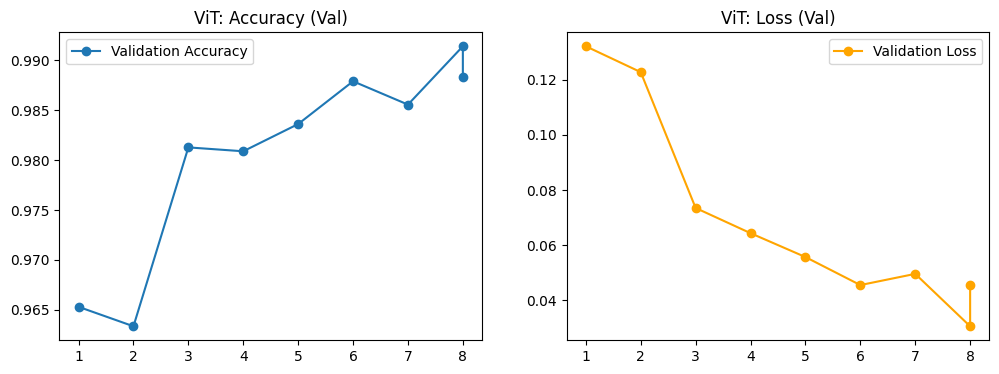

Generating Confusion Matrix for ViT-Base...


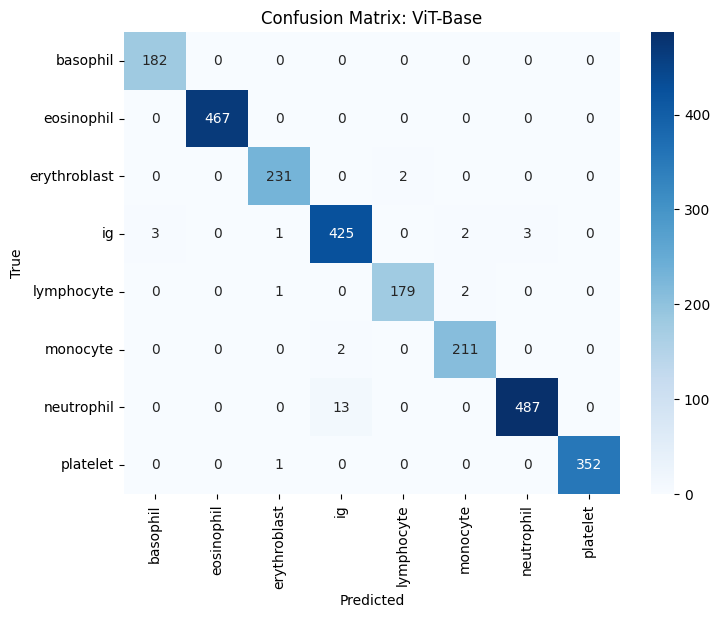

In [12]:
log_history = trainer.state.log_history
epochs = []
eval_loss = []
eval_acc = []

for entry in log_history:
    if 'eval_loss' in entry: # Eval log
        epochs.append(entry['epoch'])
        eval_loss.append(entry['eval_loss'])
        eval_acc.append(entry['eval_accuracy'])

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, eval_acc, label='Validation Accuracy', marker='o')
plt.title('ViT: Accuracy (Val)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, eval_loss, label='Validation Loss', marker='o', color='orange')
plt.title('ViT: Loss (Val)')
plt.legend()
plt.show()

# Confusion Matrix for ViT
print(f"Generating Confusion Matrix for ViT-Base...")
predictions = trainer.predict(dataset_ViT["test"])
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix: ViT-Base')
plt.show()

# VII - FINAL COMPARISON


Final Benchmarks:
               Model  Accuracy
0      Basic_Shallow  0.906396
1  Shallow_Attention  0.938378
2     EfficientNetB3  0.980889
3           ViT-Base  0.988300


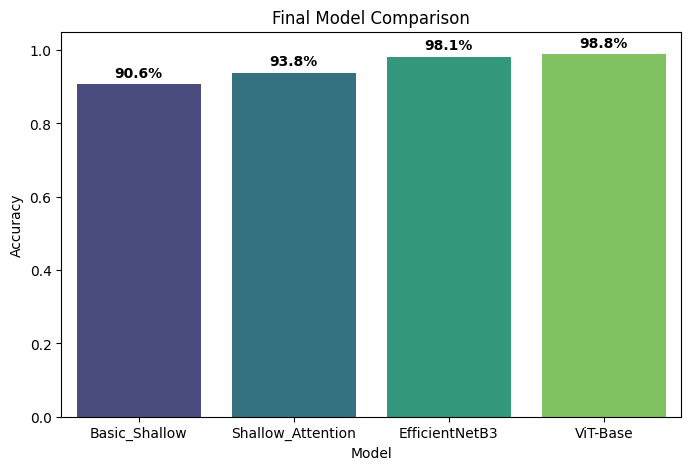

In [13]:
print("\nFinal Benchmarks:")
results_df = pd.DataFrame(evaluation_results)
print(results_df)

plt.figure(figsize=(8, 5))
sns.barplot(data=results_df, x='Model', y='Accuracy', palette='viridis', hue='Model', legend=False)
plt.title('Final Model Comparison')
plt.ylim(0, 1.05)
for index, row in results_df.iterrows():
    plt.text(index, row['Accuracy'] + 0.02, f"{row['Accuracy']*100:.1f}%", 
             color='black', ha="center", fontweight='bold')
plt.show()